In [1]:
# Import dependencies
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection
import tensorflow.keras as keras

import time
from statistics import mean, pstdev


In [2]:
def load_dataset(verbose=True):
    '''Loads the fashion-MNIST dataset and displays information about it based on the passed `verbose` bool.'''

    # Load the fashion-MNIST dataset from Keras
    (X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    
    # Display the shape and first 16 fashion images 
    if verbose:
        print(f'load_dataset() - Loaded training set of shape {X_train.shape} and training targets of shape {y_train.shape}')
        print(f'load_dataset() - Loaded test set of shape {X_test.shape} and test targets of shape {y_test.shape}')
        for i in range(16):
            plt.subplot(4, 4, i+1)
            plt.imshow(X_train[i], cmap = 'Greys_r')
        plt.show()
    
    # Reshape the images
    X_train = X_train.reshape((X_train.shape[0], 28, 28, 1)).astype('float32') / 255.0
    X_test = X_test.reshape((X_test.shape[0], 28, 28, 1)).astype('float32') / 255.0

    # Display the new shape
    if verbose:
        print(f'load_dataset() - Reshaped training set to shape {X_train.shape} and test set to shape {X_test.shape}')

    # Use one-hot encoding to convert the categorical labels into binary values
    y_train_onehot =  keras.utils.to_categorical(y_train)
    y_test_onehot =  keras.utils.to_categorical(y_test)
    
    # Display the one-hot target labels for the first element in the training and test targets
    if verbose:
        print(f'load_dataset() - One-hot encoding applied to training targets {y_train_onehot[0]} and test targets {y_test_onehot[0]}')

    # Return the training and test sets
    return X_train, y_train_onehot, X_test, y_test_onehot


In [3]:
def create_model():
    '''Creates a classifier for the fashion-MNIST dataset. Useful for model initialization in k-fold cross-validation.'''

    # Create the CNN with Sequential, ReLU, MaxPooling
    initializer = keras.initializers.GlorotNormal()
    
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(32, 3, activation='relu', kernel_initializer=initializer, input_shape=(28, 28, 1)))
    model.add(keras.layers.MaxPooling2D())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(10, activation='softmax'))

    # Compile the model with SGD optimizer
    optimizer = keras.optimizers.SGD(momentum=0.9)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Return the model
    return model


In [4]:
def validate_model(X, Y, K=5, verbose=True):
    '''Evaluate the model performance using k-fold cross-validation.
    
    Note: cannot use `sklearn.model_selection.cross_val_score` as it does not accept Keras models.
    
    '''
    # List to track the accuracy for each k-fold
    train_accuracies = []
    test_accuracies = []
    
    # SKLearn KFold model selection
    kfold = sklearn.model_selection.KFold(K, shuffle=True, random_state=1)
    
    # Evaluate by generating train and test sets for each k-fold, validate on test sets
    k_count = 1
    for i_train, i_test in kfold.split(X):
        if verbose:
            print(f'validate_model() - Evaluating k-fold {k_count}/{K}...')

        model = create_model()
        X_train, y_train, X_test, y_test = X[i_train], Y[i_train], X[i_test], Y[i_test]
        model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=verbose)
        
        _, train_accuracy = model.evaluate(X_train, y_train, verbose=verbose)
        train_accuracies.append(train_accuracy)
        
        _, test_accuracy = model.evaluate(X_test, y_test, verbose=verbose)
        test_accuracies.append(test_accuracy)
        
        # Display the accuracy of the current k-fold
        if verbose:
            print(f'validate_model() - k-fold {k_count}/{K} train accuracy: {round(train_accuracy * 100, 2)}%')
            print(f'validate_model() - k-fold {k_count}/{K} test accuracy: {round(test_accuracy * 100, 2)}%')
            print(f'validate_model() - Current mean train accuracy over all k-folds: {round(mean(train_accuracies) * 100, 2)}%')
            print(f'validate_model() - Current mean test accuracy over all k-folds: {round(mean(test_accuracies) * 100, 2)}%')
        
        k_count += 1

    return train_accuracies, test_accuracies
    

load_dataset() - Loaded training set of shape (60000, 28, 28) and training targets of shape (60000,)
load_dataset() - Loaded test set of shape (10000, 28, 28) and test targets of shape (10000,)


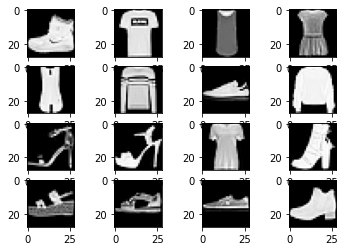

load_dataset() - Reshaped training set to shape (60000, 28, 28, 1) and test set to shape (10000, 28, 28, 1)
load_dataset() - One-hot encoding applied to training targets [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] and test targets [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
validate_model() - Evaluating k-fold 1/5...
Epoch 1/10
1500/1500 [==============================] - 17s 11ms/step - loss: 0.5210 - accuracy: 0.8093 - val_loss: 0.3451 - val_accuracy: 0.8747
Epoch 2/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.3273 - accuracy: 0.8814 - val_loss: 0.3118 - val_accuracy: 0.8849
Epoch 3/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.2770 - accuracy: 0.8982 - val_loss: 0.2751 - val_accuracy: 0.8959
Epoch 4/10
1500/1500 [==============================] - 14s 10ms/step - loss: 0.2472 - accuracy: 0.9076 - val_loss: 0.2663 - val_accuracy: 0.9022
Epoch 5/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.2190 - accuracy: 0.9189 - val_loss: 0.2663

1500/1500 [==============================] - 14s 9ms/step - loss: 0.3322 - accuracy: 0.8804 - val_loss: 0.3045 - val_accuracy: 0.8928
Epoch 3/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.2807 - accuracy: 0.8960 - val_loss: 0.2808 - val_accuracy: 0.8974
Epoch 4/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.2476 - accuracy: 0.9081 - val_loss: 0.2744 - val_accuracy: 0.9041
Epoch 5/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.2206 - accuracy: 0.9174 - val_loss: 0.2665 - val_accuracy: 0.9082
Epoch 6/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.1990 - accuracy: 0.9251 - val_loss: 0.2833 - val_accuracy: 0.9004
Epoch 7/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.1768 - accuracy: 0.9336 - val_loss: 0.2800 - val_accuracy: 0.9058
Epoch 8/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.1625 - accuracy: 0.9385 - val_loss: 0.2935 - val_accuracy: 0.9

In [5]:
start = time.time()

X_train, y_train, X_test, y_test = load_dataset()
train_accuracies, test_accuracies = validate_model(X_train, y_train, K=5)
print(f'Train Accuracy: {round(mean(train_accuracies) * 100, 2)}% +/- {round(pstdev(train_accuracies) * 100, 2)}%')
print(f'Test Accuracy: {round(mean(test_accuracies) * 100, 2)}% +/- {round(pstdev(test_accuracies) * 100, 2)}%')

runtime = round(int(time.time() - start) / 60, 2)
print(f'--- Finished in {runtime}m ---')

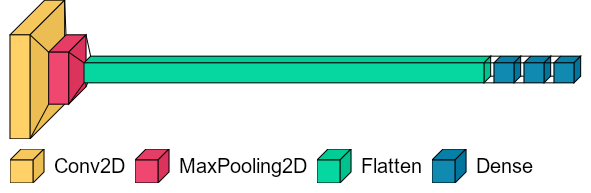

In [6]:
import visualkeras
from PIL import ImageFont


model = create_model()
font = ImageFont.truetype("arial.ttf", 20)
visualkeras.layered_view(model, legend=True, font=font) 
